In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import datetime
import pandas as pd
import itertools
import sys
import os
import math
sys.path.append('../..')
import scipy.optimize as opt
from joblib import Parallel, delayed
from functools import partial
from hyperopt import hp, tpe, fmin, Trials
from models.optim.sir_dis import SIR

# Objective Function Calculation

In [76]:
def check(start_array, duration_array, choice_array, total_resource, days):
    for i in range(1,len(start_array)):
        if(start_array[i] <= start_array[i-1] + duration_array[i-1]):
            return(0)
    if(start_array[-1]+duration_array[-1]>=days):
        return(0)
    resource_spent = np.dot(duration_array, choice_array)
    if(resource_spent != total_resource):
        return(0)
    else:
        return(1)

def get_impact(choice):
    return(1+2*choice)

def calculate_opt(intervention_day, intervention_duration, intervention_choice, days):
    R0 = 3 
    T_treat = 30
    T_trans = T_treat/R0

    N = 1e5
    I0 = 100.0

    assert(len(intervention_day) == len(intervention_duration))
    assert(len(intervention_duration) == len(intervention_choice))

    k = len(intervention_day)
    int_vec = np.ones(days)
    for intvn in range(k):
        for i in range(intervention_day[intvn],min(intervention_day[intvn]+intervention_duration[intvn],days)):
            int_vec[i] = get_impact(intervention_choice[intvn])
    
    params = [T_trans, T_treat, N, int_vec]

    state_init_values = [(N - I0)/N, I0/N, 0]
    
    solver = SIR(params, state_init_values)
    states_int_array = solver.solve_ode(time_step=1, total_no_of_days=days)
    
    S_coeficeint=0
    I_coeficeint=1
    R_coeficeint=0
#   When we have joint optimization of time and qald
#     time_weight = 0.5 + (np.arange(days)/(2*days))
#     time_weight = time_weight[::-1]
#   when we have only qald
    time_weight = np.ones(days)
    coeficeint=[S_coeficeint,I_coeficeint,R_coeficeint]
    
    grad1 = np.dot(coeficeint, states_int_array)
    grad1 = np.dot(time_weight, grad1)
    return(grad1, states_int_array)

def calculate_opt_qald(intervention_day, intervention_duration, intervention_choice, days):
    grad1, states_int_array = calculate_opt(intervention_day, intervention_duration, intervention_choice, days)
    return(grad1)

def calculate_opt_height(intervention_day, intervention_duration, intervention_choice, days):
    grad1, states_int_array = calculate_opt(intervention_day, intervention_duration, intervention_choice, days)
    infection_array = states_int_array[1]
    height = np.max(infection_array)
    return(height)

def calculate_opt_time(intervention_day, intervention_duration, intervention_choice, days):
    grad1, states_int_array = calculate_opt(intervention_day, intervention_duration, intervention_choice, days)
    infection_array = states_int_array[1]
    time = np.argmax(infection_array)
    return(time)

def hp_calculate_opt_qald(variable_params, total_resource, days):
    intervention_day = np.array(variable_params['intervention_day'])
    intervention_duration = np.array(variable_params['intervention_duration'])
    intervention_choice = np.array(variable_params['intervention_choice'])
    
    if(not check(intervention_day, intervention_duration, intervention_choice, total_resource, days)):
        return(100)
    
    grad1, states_int_array = calculate_opt(intervention_day, intervention_duration, intervention_choice, days)
        
    return(grad1)

def hp_calculate_opt_height(intervention_day, intervention_duration, intervention_choice, days):
    intervention_day = np.array(variable_params['intervention_day'])
    intervention_duration = np.array(variable_params['intervention_duration'])
    intervention_choice = np.array(variable_params['intervention_choice'])
    
    if(not check(intervention_day, intervention_duration, intervention_choice, total_resource, days)):
        return(100)
    
    grad1, states_int_array = calculate_opt(intervention_day, intervention_duration, intervention_choice, days)
    infection_array = states_int_array[1]
    height = np.max(infection_array)
    return(height)

def hp_calculate_opt_time(intervention_day, intervention_duration, intervention_choice, days):
    intervention_day = np.array(variable_params['intervention_day'])
    intervention_duration = np.array(variable_params['intervention_duration'])
    intervention_choice = np.array(variable_params['intervention_choice'])
    
    if(not check(intervention_day, intervention_duration, intervention_choice, total_resource, days)):
        return(100)
    
    grad1, states_int_array = calculate_opt(intervention_day, intervention_duration, intervention_choice, days)
    infection_array = states_int_array[1]
    time = np.argmax(infection_array)
    return(time)

def run_seir(days, int_vec):
    R0 = 3 
    T_treat = 30
    T_trans = T_treat/R0

    N = 1e5
    I0 = 100.0
    
    params = [T_trans, T_treat, N, int_vec]

    # S, E, I, R_mild, R_severe, R_severe_home, R_fatal, C, D
    state_init_values = [(N - I0)/N, I0/N, 0]
    
    solver = SIR(params, state_init_values)
    states_int_array = solver.solve_ode(time_step=1, total_no_of_days=days)
    
    
    S_coeficeint=0
    I_coeficeint=1
    R_coeficeint=0
#   When we have joint optimization of time and qald
#     time_weight = 0.5 + (np.arange(days)/(2*days))
#     time_weight = time_weight[::-1]
#   when we have only qald
    time_weight = np.ones(days)
    
    coeficeint=np.array([S_coeficeint,I_coeficeint,R_coeficeint])
    
    grad1 = np.dot(coeficeint, states_int_array)
    grad1 = np.dot(time_weight, grad1)
    
    return(grad1,states_int_array)

# No Intervention

28.268531874481702
0.3046673195985664 118


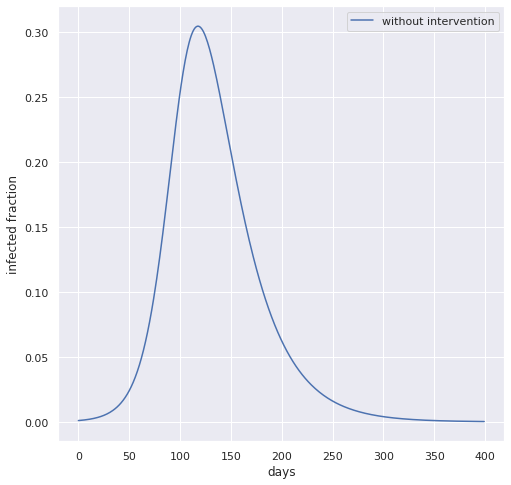

In [77]:
days = 400
grad1, states_base = calculate_opt(intervention_day=np.array([100]), intervention_duration=np.array([50]), intervention_choice=np.array([0]), days=days)
print(grad1)
height = calculate_opt_height(intervention_day=np.array([100]), intervention_duration=np.array([50]), intervention_choice=np.array([0]), days=days)
time = calculate_opt_time(intervention_day=np.array([100]), intervention_duration=np.array([50]), intervention_choice=np.array([0]), days=days)
print(height, time)
ind = np.arange(days)   # the x locations for the groups
width = 0.95        # the width of the bars: can also be len(x) sequence
plt.figure(figsize=(8,8))
plt.plot(ind, states_base[1], label='without intervention')
plt.ylabel('infected fraction')
plt.xlabel('days')
plt.legend()
plt.show()

# Grid Search

In [78]:
def grid_search(num_int, total_resource=80, day0=10, days=500):
    min_val = 100
    min_params = {}
    params = []
    min_duration = 10
    max_duration = total_resource*np.array([4,2,1])
   
    if(num_int == 1):
        start_val = [start for start in range(day0, days-min_duration, 10)]
        choice_val = [0.25, 0.5, 1]
        duration_val = [duration for duration in range(10, 4*total_resource, 5)]
        start_tuple = list(itertools.product(start_val))
        choice_tuple = list(itertools.product(choice_val))
        duration_tuple = list(itertools.product(duration_val))
        inputs = list(itertools.product(start_tuple, duration_tuple, choice_tuple))
        for inp in inputs:
            start_array = np.array(inp[0])
            duration_array = np.array(inp[1])
            choice_array = np.array(inp[2])
            if(check(start_array, duration_array, choice_array, total_resource, days)):
                params.append([start_array, choice_array, duration_array])
        
    if(num_int == 2):
        start_val = [start for start in range(day0, days-min_duration, 30)]
        choice_val = [0.25, 0.5, 1]
        duration_val = [duration for duration in range(10, 4*total_resource, 10)]
        start_tuple = list(itertools.product(start_val, start_val))
        choice_tuple = list(itertools.product(choice_val, choice_val))
        duration_tuple = list(itertools.product(duration_val, duration_val))
        inputs = list(itertools.product(start_tuple, duration_tuple, choice_tuple))
        for inp in inputs:
            start_array = np.array(inp[0])
            duration_array = np.array(inp[1])
            choice_array = np.array(inp[2])
            if(check(start_array, duration_array, choice_array, total_resource, days)):
                params.append([start_array, choice_array, duration_array])
            
    if(num_int == 3):
        start_val = [start for start in range(day0, days-min_duration, 60)]
        choice_val = [0.25, 0.5, 1]
        duration_val = [duration for duration in range(10, 4*total_resource, 20)]
        start_tuple = list(itertools.product(start_val, start_val, start_val))
        choice_tuple = list(itertools.product(choice_val, choice_val, choice_val))
        duration_tuple = list(itertools.product(duration_val, duration_val, duration_val))
        inputs = list(itertools.product(start_tuple, duration_tuple, choice_tuple))
        for inp in inputs:
            start_array = np.array(inp[0])
            duration_array = np.array(inp[1])
            choice_array = np.array(inp[2])
            if(check(start_array, duration_array, choice_array, total_resource, days)):
                params.append([start_array, choice_array, duration_array])
        
                            
    print(len(params))

    value_array = Parallel(n_jobs=40)(delayed(calculate_opt_qald)(intervention_day=par[0], intervention_duration=par[2],\
                                                             intervention_choice=par[1], days = days) for par in params)
    value_array = np.array(value_array)
    min_val = np.min(value_array)
    i = np.argmin(value_array)
    min_params['start_array'] = params[i][0]
    min_params['duration_array'] = params[i][2]
    min_params['choice_array'] = params[i][1]
    
    return(min_val, min_params)    

### Plot Results for Grid Search

54
22.715980701038443
{'start_array': array([90]), 'duration_array': array([160]), 'choice_array': array([0.5])}
0.1909917985015741 93
2286
22.679627884358585
{'start_array': array([ 70, 100]), 'duration_array': array([ 20, 150]), 'choice_array': array([0.25, 0.5 ])}
0.17604340516533548 101
1694
23.033955431609552
{'start_array': array([ 10,  70, 130]), 'duration_array': array([ 10,  50, 130]), 'choice_array': array([0.25, 0.25, 0.5 ])}
0.1983096075490318 130


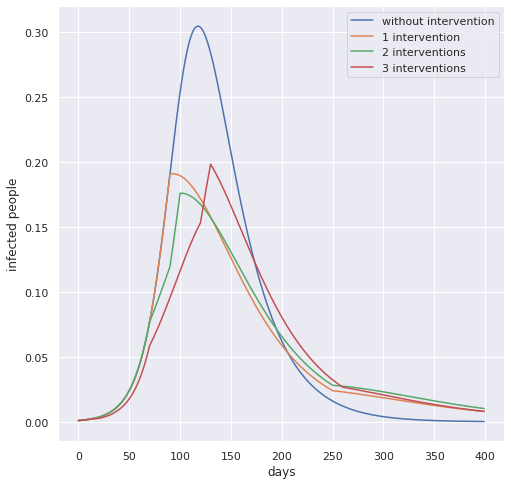

In [79]:
days = 400
#num_int = 1
min_val, min_params = grid_search(num_int=1, days=days)
print(min_val)
print(min_params)
val, states = calculate_opt(intervention_day=min_params['start_array'], intervention_duration=min_params['duration_array'],\
              intervention_choice=min_params['choice_array'], days=days)
height = calculate_opt_height(intervention_day=min_params['start_array'], intervention_duration=min_params['duration_array'],\
              intervention_choice=min_params['choice_array'], days=days)
time = calculate_opt_time(intervention_day=min_params['start_array'], intervention_duration=min_params['duration_array'],\
              intervention_choice=min_params['choice_array'], days=days)
print(height, time)
ind = np.arange(days)   # the x locations for the groups
width = 0.95        # the width of the bars: can also be len(x) sequence
plt.figure(figsize=(8, 8))
plt.plot(ind, states_base[1], label='without intervention')
plt.plot(ind, states[1], label='1 intervention')

#num_int = 2
min_val, min_params = grid_search(num_int=2, days=days)
print(min_val)
print(min_params)
val, states = calculate_opt(intervention_day=min_params['start_array'], intervention_duration=min_params['duration_array'],\
              intervention_choice=min_params['choice_array'], days=days)
height = calculate_opt_height(intervention_day=min_params['start_array'], intervention_duration=min_params['duration_array'],\
              intervention_choice=min_params['choice_array'], days=days)
time = calculate_opt_time(intervention_day=min_params['start_array'], intervention_duration=min_params['duration_array'],\
              intervention_choice=min_params['choice_array'], days=days)
print(height, time)
plt.plot(ind, states[1], label='2 interventions')

#num_int = 3
min_val, min_params = grid_search(num_int=3, days=days)
print(min_val)
print(min_params)
val, states = calculate_opt(intervention_day=min_params['start_array'], intervention_duration=min_params['duration_array'],\
              intervention_choice=min_params['choice_array'], days=days)
height = calculate_opt_height(intervention_day=min_params['start_array'], intervention_duration=min_params['duration_array'],\
              intervention_choice=min_params['choice_array'], days=days)
time = calculate_opt_time(intervention_day=min_params['start_array'], intervention_duration=min_params['duration_array'],\
              intervention_choice=min_params['choice_array'], days=days)
print(height, time)
plt.plot(ind, states[1], label='3 interventions')

plt.ylabel('infected people')
plt.xlabel('days')
plt.legend()
plt.show()

# Bayesian Search

In [80]:
def tpe_opt(num_int, total_resource=80, day0=10, days=500):
    min_duration = 10
    if(num_int==1):
        start_val = [start for start in range(day0, days-min_duration, 10)]
        choice_val = [0.25, 0.5, 1]
        duration_val = [duration for duration in range(10, 4*total_resource+1, 5)]

        variable_params = {
            'intervention_day' : [hp.choice('intervention_day', start_val)],
            'intervention_duration' : [hp.choice('intervention_duration', duration_val)],
            'intervention_choice' : [hp.choice('intervention_choice', choice_val)],
        }
        
    if(num_int==2):
        start_val = [start for start in range(day0, days-min_duration, 10)]
        choice_val = [0.25, 0.5, 1]
        duration_val = [duration for duration in range(10, 4*total_resource+1, 10)]

        variable_params = {
            'intervention_day' : [hp.choice('id_0', start_val),hp.choice('id_1', start_val)],
            'intervention_duration' : [hp.choice('du_0', duration_val),hp.choice('du_1', duration_val)],
            'intervention_choice' : [hp.choice('ic_0', choice_val),hp.choice('ic_1', choice_val)],
        }

    partial_calculate_opt = partial(hp_calculate_opt_qald, total_resource=total_resource, days=days) 
    
    searchspace = variable_params
    
    trials = Trials()
    best = fmin(partial_calculate_opt,
                space=searchspace,
                algo=tpe.suggest,
                max_evals=3000,
                trials=trials)
    
    return(best, trials)

def tpe_grid(num_int, min_params, total_resource=80, days=500):
    min_duration = 10
    window_start = 30
    if(num_int==1):
        start = int(min_params['start_array'][0] - window_start/2)
        end = int(min_params['start_array'][0] + window_start/2)
        start_val = [start for start in range(start, end)]
        choice_val = [min_params['choice_array'][0]]
        duration_val = [min_params['duration_array'][0]]

        variable_params = {
            'intervention_day' : [hp.choice('intervention_day', start_val)],
            'intervention_duration' : [hp.choice('intervention_duration', duration_val)],
            'intervention_choice' : [hp.choice('intervention_choice', choice_val)],
        }
        
    if(num_int==2):
        start = int(min_params['start_array'][0] - window_start/2)
        end = int(min_params['start_array'][0] + window_start/2)
        start_val_0 = [start for start in range(start, end)]
        start = int(min_params['start_array'][1] - window_start/2)
        end = int(min_params['start_array'][1] + window_start/2)
        start_val_1 = [start for start in range(start, end)]
        choice_val_0 = [min_params['choice_array'][0]]
        choice_val_1 = [min_params['choice_array'][1]]
        duration_val_0 = [min_params['duration_array'][0]]
        duration_val_1 = [min_params['duration_array'][1]]

        variable_params = {
            'intervention_day' : [hp.choice('id_0', start_val_0),hp.choice('id_1', start_val_1)],
            'intervention_duration' : [hp.choice('du_0', duration_val_0),hp.choice('du_1', duration_val_1)],
            'intervention_choice' : [hp.choice('ic_0', choice_val_0),hp.choice('ic_1', choice_val_1)],
        }

    partial_calculate_opt = partial(hp_calculate_opt_qald, total_resource=total_resource, days=days) 
    
    searchspace = variable_params
    
    trials = Trials()
    best = fmin(partial_calculate_opt,
                space=searchspace,
                algo=tpe.suggest,
                max_evals=3000,
                trials=trials)
    
    return(best, trials)

### Running bayesian search

In [81]:
days = 400
tpe_opt(num_int=1, days=days)

100%|██████████| 3000/3000 [01:12<00:00, 41.65trial/s, best loss: 24.366461118300727]


({'intervention_choice': 2,
  'intervention_day': 10,
  'intervention_duration': 14},
 <hyperopt.base.Trials at 0x7fdc7e0d3828>)

In [82]:
tpe_opt(num_int=2, days=days)

100%|██████████| 3000/3000 [01:58<00:00, 25.22trial/s, best loss: 28.119691256052125]


({'du_0': 3, 'du_1': 11, 'ic_0': 1, 'ic_1': 1, 'id_0': 20, 'id_1': 26},
 <hyperopt.base.Trials at 0x7fdb45676be0>)

### Bayesian search over grid search

In [83]:
_, min_params = grid_search(num_int=1, days=days)
tpe_grid(num_int=1, days=days, min_params=min_params)

54
100%|██████████| 3000/3000 [01:05<00:00, 45.74trial/s, best loss: 22.635526330686524]


({'intervention_choice': 0,
  'intervention_day': 11,
  'intervention_duration': 0},
 <hyperopt.base.Trials at 0x7fdc7e062ef0>)

In [84]:
_, min_params = grid_search(num_int=2, days=days)
tpe_grid(num_int=2, days=days, min_params=min_params)

2286
100%|██████████| 3000/3000 [01:46<00:00, 28.27trial/s, best loss: 22.57656307959835]


({'du_0': 0, 'du_1': 0, 'ic_0': 0, 'ic_1': 0, 'id_0': 23, 'id_1': 14},
 <hyperopt.base.Trials at 0x7fdc8ebd4cc0>)

# Gradient Based Methods - Frank Wolfe Algorithm

### Calculating gradients

In [61]:
def get_grad(int_vec):
    days = len(int_vec)
    num_pts = 3  # number of points used for derievative.
    grad_vec = np.ones(days)
    for i in range(10, days):
    #     i represents the ith dimension of T_transi
        val = int_vec[i]
        window_size = 0.005
        values = np.random.uniform(val-window_size, val+window_size, num_pts)
        f_values = np.ones_like(values)
        for j,value in enumerate(values):
            int_vec[i] = value
            f_values[j],_ = run_seir(days, int_vec)
        values = np.append(values,val)
        int_vec[i] = val
        fval,_ = run_seir(days, int_vec)
        f_values = np.append(f_values,fval)
        derivative = np.gradient(f_values, values, edge_order=2)
        grad_vec[i] = derivative[-1]
    return(grad_vec)

### Formulating optimization problem

In [62]:
from pulp import *
def opt_step(grad):
    prob = LpProblem("Minimization over constrained space",LpMinimize)

    day_list = list((np.arange(400-10)).astype(str))

    int_days = LpVariable.dicts("day",day_list,lowBound=1,upBound=3,cat='Continuous')

#     grad = get_grad(np.ones(400))

    prob += lpSum([grad[int(i)]*int_days[i] for i in day_list]) #objective function
    prob += lpSum([int_days[f] for f in day_list]) <= 560.0-10.0 #TotalResource
    prob.solve()
    opt_val = np.ones(400)
    for v in prob.variables():
        idx = v.name.split('_')[-1]
        opt_val[int(idx)+10] = v.varValue
        
    return(opt_val)

### Main algo

/home/users/bhardwaj/env_covid/lib/python3.7/site-packages/pulp/pulp.py:1114: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


20.776992111067983
18.685677095611947
18.271839505950453
18.159919697731553
18.067299671169643


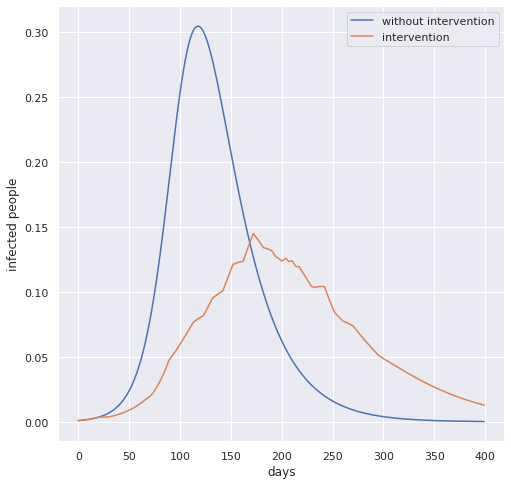

In [64]:
days = 400
num_iter = 20
best_val = 50
int_vec = np.ones(days)
best_int_vec = np.ones(days)
for i in range(num_iter):
    gradient = get_grad(int_vec)
    opt = opt_step(gradient)
    gamma = 2.0/(3+i)
    int_vec = int_vec + gamma*(opt-int_vec)
    value,_ = run_seir(int_vec=int_vec,days=days)
    if(value < best_val):
        best_val = value
        best_int_vec = int_vec
        print(best_val)
    
val, states = run_seir(days=days, int_vec=best_int_vec)
ind = np.arange(days)   # the x locations for the groups
width = 0.95        # the width of the bars: can also be len(x) sequence
plt.figure(figsize=(8, 8))
plt.plot(ind, states_base[1], label='without intervention')
plt.plot(ind, states[1], label='intervention')
plt.ylabel('infected people')
plt.xlabel('days')
plt.legend()
plt.show()

### Discretize FW results

In [65]:
int_vec = best_int_vec.copy()
int_vec[int_vec<1.25]=1
int_vec[np.logical_and(int_vec<1.75, int_vec>1.25)] = 1.5
int_vec[int_vec>1.75] = 2

In [66]:
int_vec

array([1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 2. , 2. , 2. , 2. , 2. , 2. ,
       2. , 2. , 2. , 2. , 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5,
       1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5,
       1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5,
       1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1.5, 1.5,
       1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5,
       1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 2. , 2. , 2. , 2. ,
       2. , 2. , 2. , 2. , 2. , 2. , 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5,
       1.5, 1.5, 2. , 2. , 2. , 2. , 2. , 2. , 2. , 2. , 2. , 2. , 1.5,
       1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 2. , 2. , 2. , 2. ,
       2. , 2. , 2. , 2. , 2. , 2. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 2. , 2. , 2. , 2. , 2. , 2. , 2. , 2. , 2.

In [67]:
np.sum(int_vec)

540.0

In [68]:
# num=0
# for i in range(len(int_vec)):
#     if(num>=3):
#         break
#     if(int_vec[-i]==1.5):
#         int_vec[-i]=1
#         num+=1
# print(np.sum(int_vec))

18.674967388495354


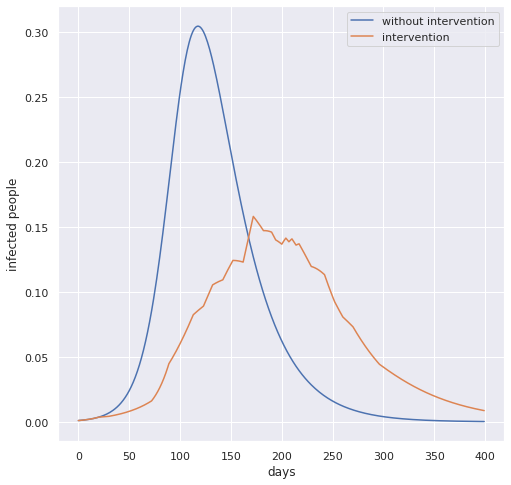

In [70]:
days=400
curve, states = run_seir(days=days, int_vec=int_vec)
best_dis_val = np.sum(curve)
print(best_dis_val)
ind = np.arange(days)   # the x locations for the groups
width = 0.95        # the width of the bars: can also be len(x) sequence
plt.figure(figsize=(8, 8))
plt.plot(ind, states_base[1], label='without intervention')
plt.plot(ind, states[1], label='intervention')
plt.ylabel('infected people')
plt.xlabel('days')
plt.legend()
plt.show()